# Soil Moisture analysis using data from ESA CCI SM
## Objectives
1. Download all data from the ESA Soil Moisture Climate Change Initiative(ESA CCI SM). That is the **COMBINED** product
2. Extract data over 2 regions and calculate daily mean soil moisture values
   - Iberian Peninsula
   - Germany-Austria-Switzerland region
3. Create 4 plots
   - mean global soil moisture in **spring**
   - mean global soil moisture in **summer**
   - mean global soil moisture in **automn**
   - mean global soil moisture in **winter** 

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import xarray as xr
import rioxarray
import numpy as np
from scipy.signal import savgol_filter

import seaborn as sns
# Set the style
sns.set_style("darkgrid")

import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

In [2]:
DATA_PATH = Path('/home/io/ASTROSAT/code/climers')

### Download all the the data for the year 2021

In [3]:
#! wget -e robots=off --mirror --no-parent -r https://dap.ceda.ac.uk/neodc/esacci/soil_moisture/data/daily_files/COMBINED/v07.1/2021/ 

### Examine the Soil Moisture product

In [4]:
all_data_path = DATA_PATH.joinpath('raw','global').glob('*.nc')
list_data = sorted([data for data in list(all_data_path)])
print (f" There are {len(list_data)} SM products")

 There are 365 SM products


In [5]:
first_product = list_data[0]

In [5]:
sm_first_product = xr.open_dataset(first_product)

In [6]:
sm_first_product

<xarray.Dataset>
Dimensions:         (time: 1, lat: 720, lon: 1440)
Coordinates:
  * time            (time) datetime64[ns] 2021-01-01
  * lat             (lat) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    sm              (time, lat, lon) float32 ...
    sm_uncertainty  (time, lat, lon) float32 ...
    flag            (time, lat, lon) float32 ...
    freqbandID      (time, lat, lon) float32 ...
    dnflag          (time, lat, lon) float32 ...
    mode            (time, lat, lon) float32 ...
    sensor          (time, lat, lon) float64 ...
    t0              (time, lat, lon) datetime64[ns] ...
Attributes: (12/44)
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    institution:                  TU Wien (AUT); VanderSat B.V. (NL)
    contact:                      cci_sm_contact@eodc.eu
    source:                       WARP 5.5R1.1/AMI-WS/ERS12 Level 2 Soil Mois...
    platform:                     Nimbus 7, DMSP, TRMM, AQUA, Coriolis, GCOM-...
    processing_level:             Quality-controlled, super-collocated (L3S) ...
    ...                           ...
    geospatial_lon_units:         degrees_east
    geospatial_lat_resolution:    0.25 degree
    geospatial_lon_resolution:    0.25 degree
    spatial_resolution:           25km
    time_coverage_start:          20210101T000000Z
    time_coverage_end:            20210101T235959Z

#### Access data variables

In [7]:
print(f"Dimensions: \n {sm_first_product['sm'].dims}")
print(f"\n Attributes: \n {sm_first_product['sm'].attrs}")
print(f"\n {sm_first_product['sm'].coords}")
print(f"\n Values: \n {sm_first_product['sm'].values[0][240:290, 670:730]}")


Dimensions: 
 ('time', 'lat', 'lon')

 Attributes: 
 {'dtype': 'float32', 'units': 'm3 m-3', 'valid_range': array([0., 1.], dtype=float32), 'long_name': 'Volumetric Soil Moisture', 'standard_name': 'soil_moisture_content', 'ancillary_variables': 'sm_uncertainty flag t0', '_CoordinateAxes': 'time lat lon'}

 Coordinates:
  * time     (time) datetime64[ns] 2021-01-01
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

 Values: 
 [[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [0.02707297 0.08591723 0.08441251 ... 0.08595068 0.08545204 0.08624663]
 [0.02485442 0.08245096 0.08368313 ... 0.0851608  0.08353032        nan]
 [0.08610971 0.08059346 0.083499   ... 0.08632673 0.08379265 0.08114736]]


#### Visualize the global soil moisture product

In [6]:
def plot_basemap(data,
                ll_lon, 
                ll_lat,
                ur_lon, 
                ur_lat,
                grid,
                figsize,
                title):
    """Plot Global Soil mositure map with a basemap
    """
    fig = plt.figure(figsize=figsize)
    m = Basemap(projection='merc',
               llcrnrlon=ll_lon,
               llcrnrlat=ll_lat,
               urcrnrlon=ur_lon,
               urcrnrlat=ur_lat,
               resolution='i')
    
    # add basemap
    m.bluemarble()
    m.drawcountries(linewidth=1)
    # draw coordinates
    m.drawmeridians(np.arange(ll_lon,ur_lon,grid),labels=[0,0,0,1], linewidth=0.5, color='None') #longitudes
    m.drawparallels(np.arange(ll_lat,ur_lat,grid),labels=[1,0,0,1], linewidth=0.5, color='None') #latitudes
    # get coordinates (lat,lon) from the data
    lats = data['lat'].values
    lons = data['lon'].values

    lon,lat = np.meshgrid(lons, lats)
    x,y = m(lon, lat)
    c_schema = m.pcolor(x,y,data=data['sm'].values, cmap='jet',vmin=0.1, vmax=0.5)
    #cbar = fig.colorbar(c_schema, shrink=0.80, aspect=50)
    cbar = m.colorbar(c_schema, shrink=0.80, aspect=50)
    cbar.set_label("Volumetric SM [m^3]")
    plt.xlabel('Longitude', labelpad=20)
    plt.ylabel('Latitude', labelpad=30)
    plt.title(title)

In [7]:
# take the SM average of the first month for visualization purposes
products_path = list_data[:31]
products = xr.open_mfdataset(products_path, combine='nested', concat_dim='time')
sm_global = products.mean(dim='time')

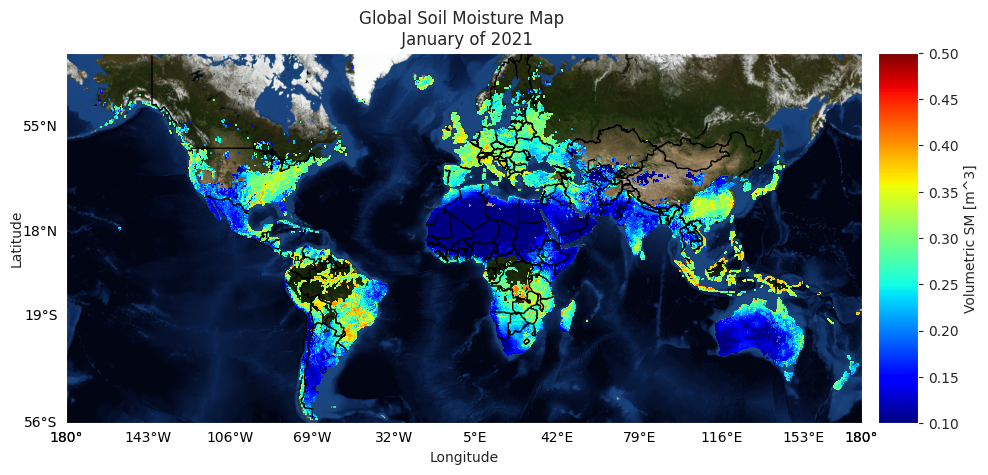

In [8]:
# Global map
ll_lon=-180
ll_lat=-56
ur_lon=180
ur_lat=70

plot_basemap(sm_global, 
            ll_lon, ll_lat,
            ur_lon, ur_lat,
            37, (11,7),
            'Global Soil Moisture Map \n January of 2021')

#### Subset the global map over the two regions

In [9]:
def subset_data(data,
               lat1,lon1,
               lat2,lon2):
    # Iberian Peninsula  subset
    region1 = data.sel(lon=slice(lon1[0], lon1[1]), 
                          lat=slice(lat1[1], lat1[0]))
    
    # Iberian Peninsula  subset
    region2 = data.sel(lon=slice(lon2[0], lon2[1]), 
                          lat=slice(lat2[1], lat2[0]))
    return region1, region2

In [10]:
# Iberian Peninsula coordinates
ib_lat = [34.4, 45.3]
ib_lon = [-9.4, 5.6]

# D-A-CH coordinates
ch_lat = [45.8, 55.1]
ch_lon = [5.9, 17.2]

In [11]:
sm_ib_susbet, sm_ch_susbet = subset_data(sm_global,
                                        ib_lat, ib_lon,
                                        ch_lat, ch_lon)

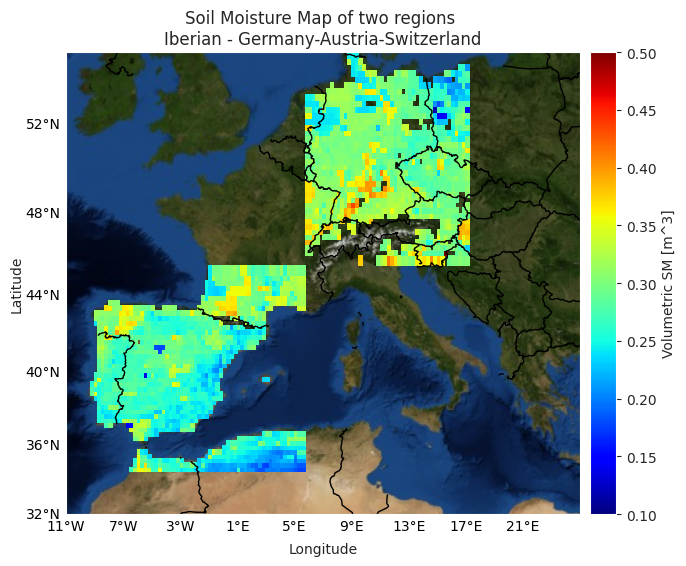

In [12]:
# Merge both regions so that we can see them on the map
sm_merge = xr.merge([sm_ib_susbet, sm_ch_susbet])

ll_lon=-11
ll_lat=32
ur_lon=25
ur_lat=55

plot_basemap(sm_merge, 
             ll_lon, ll_lat,
             ur_lon, ur_lat,
             4, (8,6),
             'Soil Moisture Map of two regions \n'
             'Iberian - Germany-Austria-Switzerland')

We can observe the presence of NaN values over the Eastern part of Austria and the borders of Italy. These gaps occur due to the influence of strong topography and snow cover over the mountains. In areas characterized by significant topographic variations, dense vegetation, ice, or water, meaningful soil moisture values cannot be derived; hence, they should be masked out from the analysis.


### Multi-temporal Analysis
- subset all the multi-temporal products over our AOI
- calculate daily mean soil moisture values for the whole year
- Plot the average SM values for the two regions
- Create a time-series plot

In [13]:
# map1 - Iberian
ll_lon_m1=-11
ll_lat_m1=32
ur_lon_m1=10
ur_lat_m1=47
grid_m1 = 4 

# map 2 - G-A-S
ll_lon_m2=2
ll_lat_m2=44
ur_lon_m2=24
ur_lat_m2=57
grid_m2 = 4 

#### Calculate annual averages correctly
When converting dataset from monthly frequency into annual frequency, we need to take the length of each month into account since not each month is created equal. For example, February has 28 days whereas December has 31. This can be done as follows:
- **Determine the length of each month**
- **Calculate the weights**. We devide the length of each month by the total length of all months. Months of shorter length are assigned to a lower weight to compensate for being a shorter month
- **Assign the weights to the soil moisture data**

In [14]:
def weighted_months_avg(ds, var, time="year"):
    """
    Correctly calculating yearly and seasonal averages
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month
    # Calculate the weights
    weights = month_length.groupby(f"time.{time}") / month_length.groupby(f"time.{time}").sum()

    # Subset our dataset for our variable
    obs = ds[var]
    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Assign the weights to the dataset
    obs_sum = (obs * weights).groupby(f"time.{time}").sum(dim="time")
    ones_out = (ones * weights).groupby(f"time.{time}").sum(dim="time")
    ds_weighted = obs_sum / ones_out
    ds_weighted['sm'] = ds_weighted
    return ds_weighted


def plot_avg_sm(sm_ib,
               sm_ch):
    """Plot mean soil moisutre values for both regions
    """
    fig = plt.figure(figsize=(9,9))
    
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    map1 = Basemap(projection='merc',
                   llcrnrlon=ll_lon_m1,
                   llcrnrlat=ll_lat_m1,
                   urcrnrlon=ur_lon_m1,
                   urcrnrlat=ur_lat_m1,
                   resolution='i',
                   ax=ax1)
    
    map1.bluemarble()
    map1.drawcountries(linewidth=1)
    # draw coordinates
    map1.drawmeridians(np.arange(ll_lon_m1,ur_lon_m1,grid_m1),labels=[0,0,0,1], linewidth=0.5, color='None') #longitudes
    map1.drawparallels(np.arange(ll_lat_m1,ur_lat_m1,grid_m1),labels=[1,0,0,1], linewidth=0.5, color='None') #latitudes
    
    lats = sm_ib_susbet['lat'].values
    lons = sm_ib_susbet['lon'].values
    lon,lat = np.meshgrid(lons, lats)
    x,y = map1(lon, lat)
    c_schema_m1 = map1.pcolor(x,y,data=sm_ib['sm'][0,:,:].values, cmap='jet',vmin=0.1, vmax=0.5)
    cbar = map1.colorbar(c_schema_m1, shrink=0.80, aspect=50)
    cbar.set_label("Volumetric SM [m^3]")
    plt.xlabel('Longitude', labelpad=20)
    plt.ylabel('Latitude', labelpad=30)
    plt.title('Iberian Peninsula \n Mean SM values')
    
    
    map2 = Basemap(projection='merc',
                   llcrnrlon=ll_lon_m2,
                   llcrnrlat=ll_lat_m2,
                   urcrnrlon=ur_lon_m2,
                   urcrnrlat=ur_lat_m2,
                   resolution='i',
                   ax=ax2)
    
    map2.bluemarble()
    map2.drawcountries(linewidth=1)
    # draw coordinates
    map2.drawmeridians(np.arange(ll_lon_m2,ur_lon_m2,grid_m2),labels=[0,0,0,1], linewidth=0.5, color='None') #longitudes
    map2.drawparallels(np.arange(ll_lat_m2,ur_lat_m2,grid_m2),labels=[1,0,0,1], linewidth=0.5, color='None') #latitudes
    
    lats_m2 = sm_ch_susbet['lat'].values
    lons_m2 = sm_ch_susbet['lon'].values
    lon_m2,lat_m2 = np.meshgrid(lons_m2, lats_m2)
    xx,yy = map2(lon_m2, lat_m2)
    c_schema_m2 = map2.pcolor(xx,yy,data=sm_ch['sm'][0,:,:].values, cmap='jet',vmin=0.1, vmax=0.5)
    cbar = map2.colorbar(c_schema_m2, shrink=0.80, aspect=50)
    cbar.set_label("Volumetric SM [m^3]")
    plt.xlabel('Longitude', labelpad=20)
    plt.ylabel('Latitude', labelpad=30)
    plt.title('Germany-Austria-Switzerland \n Mean SM values')

    mean_ib = np.nanmean(sm_ib['sm'].values)
    mean_ch = np.nanmean(sm_ch['sm'].values)
    
    sm_ib.plot.hist(bins=50, xlim=(0.1, 0.5), ax=ax3)
    sm_ch.plot.hist(bins=50, xlim=(0.1, 0.5), ax=ax4)
    
    ax3.axvline(x = mean_ib, color = 'r', label='Mean SM')
    ax3.set_xlabel('Volumetric SM [m^3]')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.set_title('')

    ax4.axvline(x = mean_ch, color = 'r', label='Mean SM')
    ax4.set_xlabel('Volumetric SM [m^3]')
    ax4.set_ylabel('Frequency')
    ax4.set_title('')
    ax4.legend()
    plt.tight_layout()

In [15]:
# laod all 365 dataset
sub_data_path = DATA_PATH.joinpath('raw','global').glob('*.nc')
list_data_sub = sorted([data for data in list(sub_data_path)])

In [16]:
# Load all 365 data and concatenate them into as single array
sm_global = xr.open_mfdataset(list_data_sub, combine='nested', 
                              concat_dim='time', chunks={'time':120}
                             )

##### Subset multi-temporal data over our AOI

In [17]:
# Create a subset from the yearly soil moisture data
sm_ib_yearly, sm_ch_yearly = subset_data(sm_global,
                                        ib_lat, ib_lon,
                                        ch_lat, ch_lon)

##### Calculate the mean SM values over the year and plot the maps

In [18]:
sm_ib_yearly_avg = weighted_months_avg(sm_ib_yearly, 'sm')
sm_ch_yearly_avg = weighted_months_avg(sm_ch_yearly, 'sm')

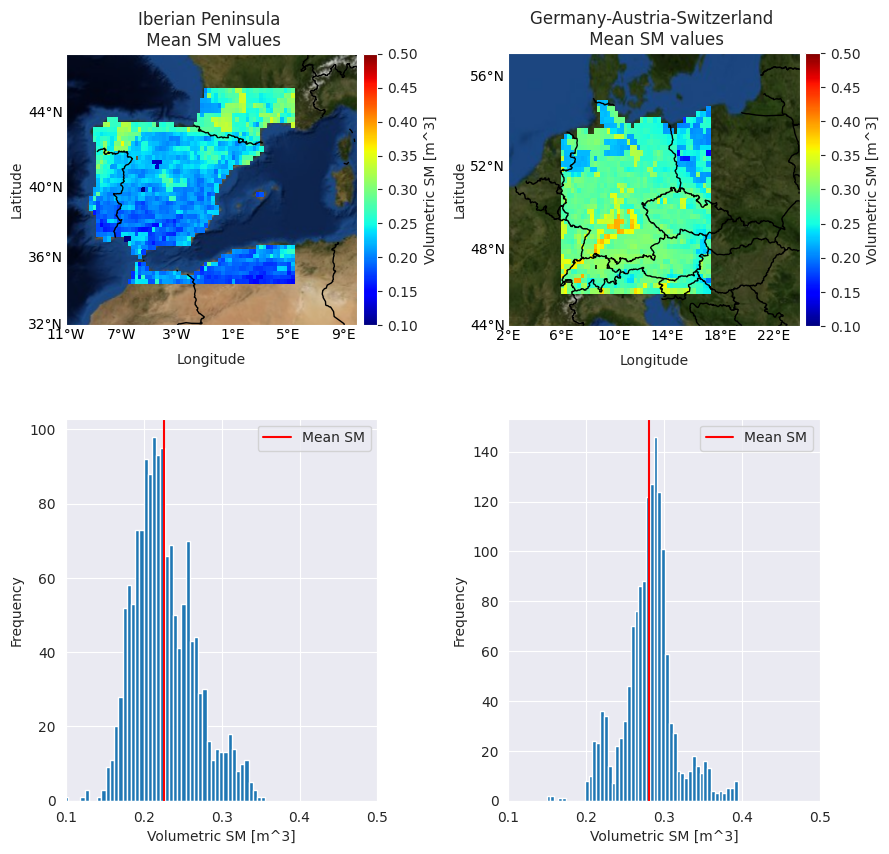

In [19]:
plot_avg_sm(sm_ib_yearly_avg, sm_ch_yearly_avg)

### Plot uncertainty from the yearly average data

In [20]:
def plot_uncertainty(sm_ib,
                     sm_ch
                    ):
    data_list = [sm_ib['sm'], sm_ib['sm_uncertainty'],
                 sm_ch['sm'], sm_ch['sm_uncertainty']]
    
    width = 8
    height = 7
    fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(width,height), constrained_layout=True)
    titles = ['Soil Moisture \n Iberian Peninsula', 'Soil Moisture uncertainty \n Iberian Peninsula',
              'Soil Moisture \n D-A-CH','Soil Moisture uncertainty \n D-A-CH']
    for i, (data, title, ax) in enumerate(zip(data_list,titles, axes.flatten())):
        im = data.plot(ax=ax, add_colorbar=False, cmap='jet')
        ax.set_title(title)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        clib = plt.colorbar(im)

In [21]:
# take the yearly average
sm_ib_avg_un = sm_ib_yearly.groupby('time.year').mean(dim='time')
sm_ch_avg_un = sm_ch_yearly.groupby('time.year').mean(dim='time')

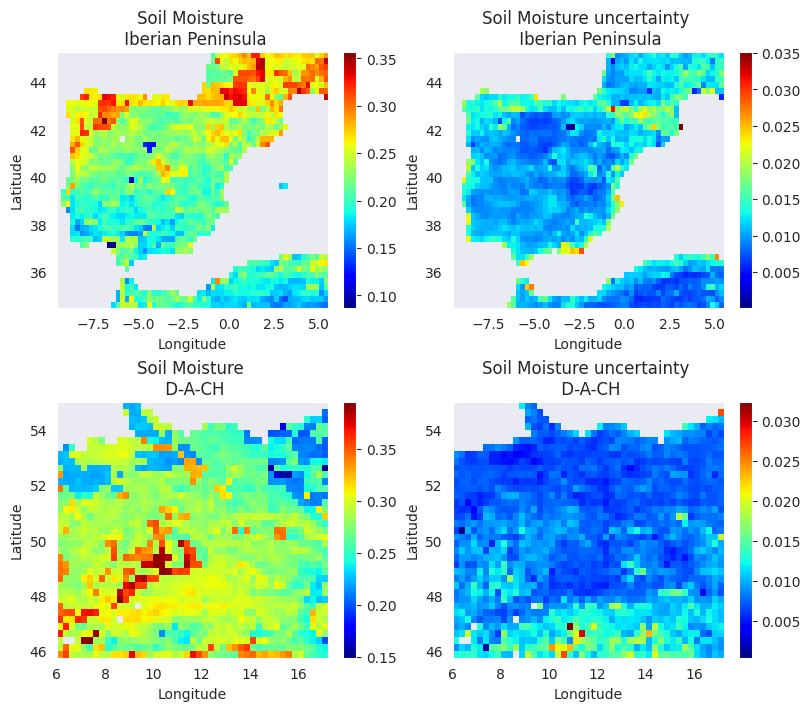

In [39]:
plot_uncertainty(sm_ib_avg_un,
                 sm_ch_avg_un)

Regarding Iberrian Peninsula region, we see higher uncertainty soil moisture values along the South coast. 
This is because some part of the coast is occuped by urban areas and in other parts there are high rocky mountains.
Hence, soil moisture measurements can not be taken over urban areas and are not reliable over rocky mountains.

Regarding the other region, We have higher uncertainty soil moisture values on the South part. This is where the high mountenous areas are located and it is most likely to be covered by snow

### Time series analysis
- Calcualte the average of soil mositure values for every product. Collate all average values into an array
- Create a line plot to see trends

In [22]:
def plot_line(data1, 
              data2,
              title,
              smooth=False):
    """Plot soil mositure time series data
    """
    fig, ax = plt.subplots(1, figsize=(11,4))
    if smooth:
        sns.lineplot(data=data1, x='date', y='sm', linestyle='dashdot', label="Iberia")
        sns.lineplot(data=data2, x='date', y='sm', linestyle='dashdot', label="D-A-CH")
        # smooth
        sns.lineplot(data=data1, x='date', y='sm_smooth',color='k',linewidth=1.1)
        sns.lineplot(data=data2, x='date', y='sm_smooth',color='k',linewidth=1.1)
        plt.xticks(rotation=50)
        plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    else:
        sns.lineplot(data=data1, x='date', y='sm', linestyle='dashdot', label="Iberia")
        sns.lineplot(data=data2, x='date', y='sm', linestyle='dashdot', label="D-A-CH")        
        plt.xticks(rotation=50)
        plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
        
    # G-A-CH
    x_min_ch = pd_min_ch['date'].values[0]
    y_min_ch = pd_min_ch['sm'].values[0]
    x_max_ch = pd_max_ch['date'].values[0]
    y_max_ch = pd_max_ch['sm'].values[0]
    date_minCH_str = str(pd_min_ch['date'])[4:16]
    date_maxCH_str = str(pd_max_ch['date'])[4:15]
    
    # Iberian
    x_min = pd_min_sm['date'].values[0]
    y_min = pd_min_sm['sm'].values[0]
    x_max = pd_max_sm['date'].values[0]
    y_max = pd_max_sm['sm'].values[0]
    date_min_str = str(pd_min_sm['date'])[4:16]
    date_max_str = str(pd_max_sm['date'])[4:15]
    
    # Iberian
    plt.plot(x_min, y_min, marker='*', ls='none', ms=10, color='g')
    plt.plot(x_max, y_max, marker='*', ls='none', ms=10, color='r')
    plt.annotate(date_min_str, [x_min,y_min], xytext=(x_min, y_min-0.0050))
    plt.annotate(date_max_str, [x_max,y_max], xytext=(x_max, y_max))
    
    # G-A-CH
    plt.plot(x_min_ch, y_min_ch, marker='*', ls='none', ms=10, color='g', label='low SM')
    plt.plot(x_max_ch, y_max_ch, marker='*', ls='none', ms=10, color='r', label='max SM')
    plt.annotate(date_minCH_str, [x_min_ch,y_min_ch], xytext=(x_min_ch, y_min_ch+0.0003))
    plt.annotate(date_maxCH_str, [x_max_ch,y_max_ch], xytext=(x_max_ch, y_max_ch))
    
    plt.xlabel('Dates')
    plt.ylabel("Volumetric SM [m^3]")
    plt.title(title)
    plt.legend()


In [23]:
dates = sm_ib_yearly['time'].values

# Compute the average SM value for each raster
avg_sm_ib_values = [np.nanmean(val) for val in sm_ib_yearly['sm'].values]
avg_sm_ch_values = [np.nanmean(val) for val in sm_ch_yearly['sm'].values]

# Build a Dataframe with the average SM values so that we can plot them
pd_avg_sm_ib = pd.DataFrame({'sm':avg_sm_ib_values, 'date':dates})
pd_avg_sm_ch = pd.DataFrame({'sm':avg_sm_ch_values, 'date':dates})

In [24]:
# below we calculate min/max values of SM to be used
# for annotation on the graph
# Iberian
min = pd_avg_sm_ib['sm'].min()
max = pd_avg_sm_ib['sm'].max()
pd_min_sm = pd_avg_sm_ib.loc[pd_avg_sm_ib['sm'] == min]
pd_max_sm = pd_avg_sm_ib.loc[pd_avg_sm_ib['sm'] == max]

# G-A-CH
min_ch = pd_avg_sm_ch['sm'].min()
max_ch = pd_avg_sm_ch['sm'].max()
pd_min_ch = pd_avg_sm_ch.loc[pd_avg_sm_ch['sm'] == min_ch]
pd_max_ch = pd_avg_sm_ch.loc[pd_avg_sm_ch['sm'] == max_ch]

In [25]:
def smooth_out(region1, region2):
    """Smooth out wiggly plots
    """
    # smooth out the plot
    region1['dates_numeric'] = region1['date'].astype(np.int64) // 10**12
    region2['dates_numeric'] = region2['date'].astype(np.int64) // 10**12
    
    window_length = 20  
    polyorder = 3  
    region1['sm_smooth'] = savgol_filter(region1['sm'], window_length, polyorder)
    region2['sm_smooth'] = savgol_filter(region2['sm'], window_length, polyorder)
    return region1, region2

In [26]:
pd_avg_sm_ib, pd_avg_sm_ch = smooth_out(pd_avg_sm_ib, pd_avg_sm_ch)

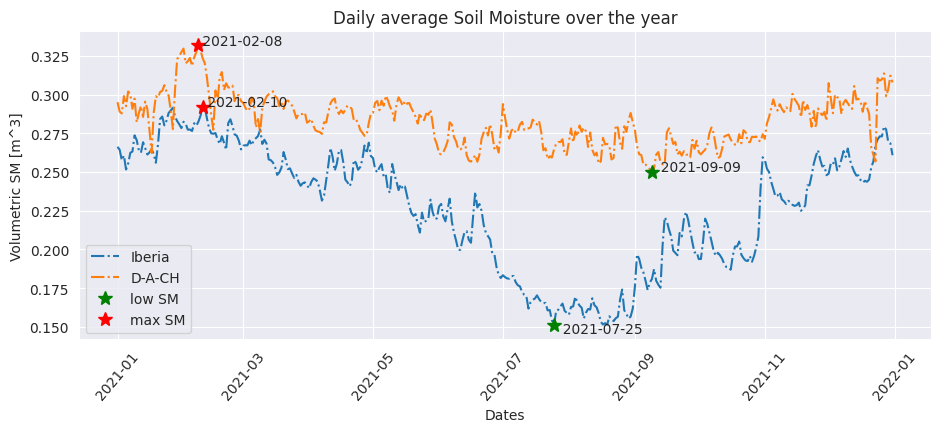

In [37]:
plot_line(pd_avg_sm_ib, pd_avg_sm_ch, title='Daily average Soil Moisture over the year')

### Calculate the average SM for each season
Seasons based on the UK MET Office are defined as:
- **Spring**: March, April, May
- **Summer**: June, July, August
- **Autumn**: September, October, November
- **Winter**: December, January, February

Sources:
- [MET office](https://www.metoffice.gov.uk/weather/learn-about/weather/seasons/spring/when-does-spring-start)
- [calendar](https://www.meteoswiss.admin.ch/weather/weather-and-climate-from-a-to-z/calendar-astronomical-and-meteorological-seasons.html)

In [31]:
def plot_seasons(data,
                 ll_lon,
                 ll_lat,
                 ur_lon,
                 ur_lat,
                 width,
                 height,
                 vmin=0.1,
                 vmax=0.5,):
    """Plot seasonal maps
    """
    
    fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(width, height), constrained_layout=True)
    titles = ['Spring','Summer', 'Autumn', 'Winter']
    for i, (season, ax) in enumerate(zip(('MAM','JJA','SON','DJF'), axes.flatten())):
        im = data['sm'].sel(season=season)
        # create a basemap for each plot
        map = Basemap(projection='merc',
                       llcrnrlon=ll_lon,
                       llcrnrlat=ll_lat,
                       urcrnrlon=ur_lon,
                       urcrnrlat=ur_lat,
                       resolution='i',
                       ax=ax)
        
        map.bluemarble()
        map.drawcountries(linewidth=1)
        # draw coordinates
        map.drawmeridians(np.arange(ll_lon, ur_lon, grid),labels=[0,0,0,1], linewidth=0.5, color='None') #longitudes
        map.drawparallels(np.arange(ll_lat, ur_lat, grid),labels=[1,0,0,1], linewidth=0.5, color='None') #latitudes
        lats = im['lat'].values
        lons = im['lon'].values
        lon,lat = np.meshgrid(lons, lats)
        x,y = map(lon, lat)
        c_schema_m1 = map.pcolor(x,y,data=im.values, cmap='jet',vmin=0.1, vmax=0.5)
        
        for ax, title in zip(axes.flat,titles):
            ax.set_title(title)
            ax.set_xlabel('Longitude', labelpad=20)
            ax.set_ylabel('Latitude', labelpad=30)
    # add colorbar
    clib = fig.colorbar(c_schema_m1, ax=axes.flat, orientation = 'horizontal', shrink=0.50, aspect=50)
    clib.set_label("Volumetric SM [m^3]")


In [32]:
temp_ib = sm_ib_yearly
temp_ch = sm_ch_yearly

In [33]:
# weighted seasonal average
var = 'sm'
temp_season_ib = weighted_months_avg(temp_ib, var, time="season")
temp_season_ch = weighted_months_avg(temp_ch, var, time="season")

# #### unweighted average #######
# temp_season_ib = temp_ib.groupby('time.season').mean(dim='time')
# temp_season_ch = temp_ch.groupby('time.season').mean(dim='time')

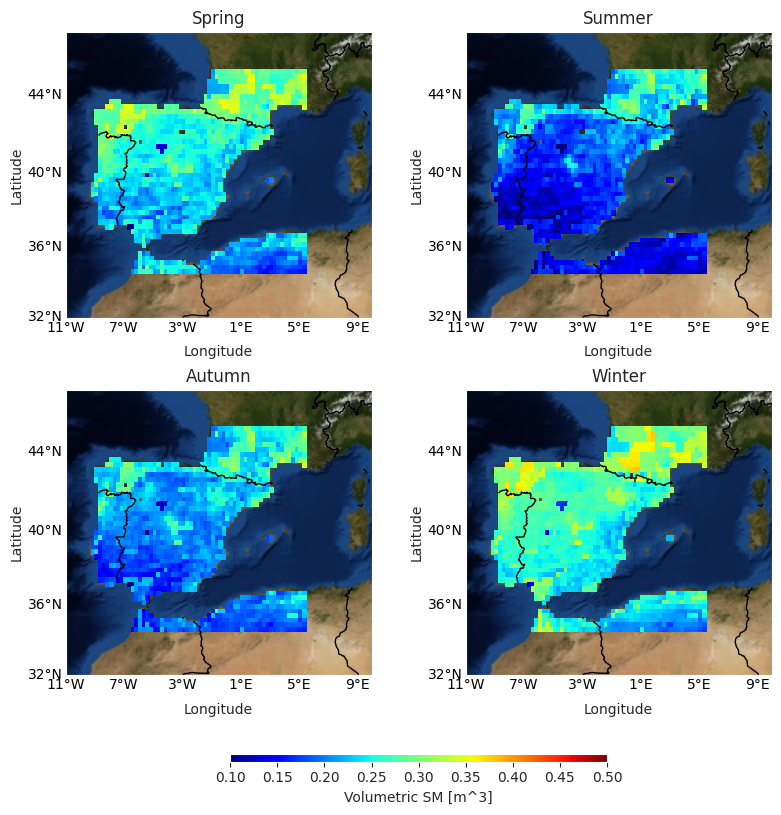

In [34]:
# coordinates of the region Iberian coordinates
ll_lon_ib=-11
ll_lat_ib=32
ur_lon_ib=10
ur_lat_ib=47
grid = 4 

plot_seasons(temp_season_ib,
            ll_lon_ib,
            ll_lat_ib,
            ur_lon_ib,
            ur_lat_ib,
            width=8,
            height=8
            )

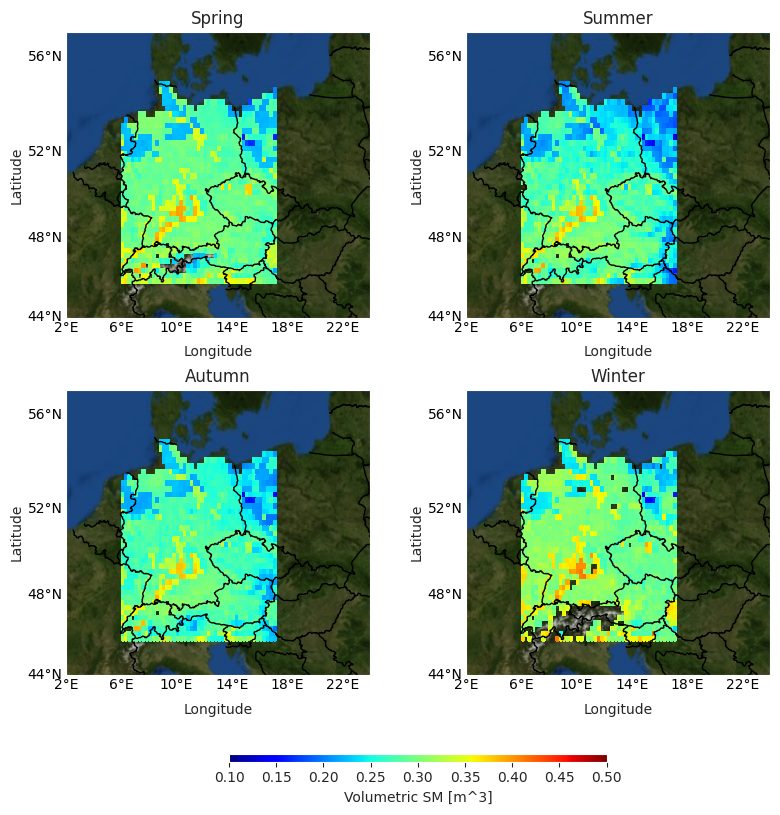

In [35]:
# coordinates of the region G-A-S
ll_lon_ch=2
ll_lat_ch=44
ur_lon_ch=24
ur_lat_ch=57
grid = 4 

plot_seasons(temp_season_ch,
            ll_lon_ch,
            ll_lat_ch,
            ur_lon_ch,
            ur_lat_ch,
            width=8,
            height=8
            )

**Conclusion**
- The average soil moisture for the region of Germany-Austria-Switzerland is high troughout the year. On the other hand, for the Iberian Peninsula, there is a big dip on the graph during summer time where the soil moisture is very low. When summer is over, the soil moisture starts increasing for Autumn and get even higher in winter

**Addittional**
- Colelct precipitation data over our two regions and validate the seasonal soil mositure results. We could create a linear regression model between precipitation and soil moisutre values to observe the degree of correlation

# THE END

### EXPERIMENTAL STUFF

In [ ]:
def remove_background(ds_weighted):
    data_array_nan = []
    num_seasons = len(ds_weighted['season'])
    # Loop through each array within the 'season' dimension
    for season_index in range(num_seasons):
        # Select the current array using array indexing
        current_array = ds_weighted.isel(season=season_index)
        # Replace zeros with NaN in the current array
        current_array_nan = current_array.where(current_array != 0, np.nan)
        # Add the current array with NaN-replaced values to the new xarray object
        data_array_nan.append(current_array_nan)
        
    ds = xr.concat(data_array_nan, dim='season')
    return ds

def weighted_seasons2(ds):
    month_length = temp_ib.time.dt.days_in_month
    weights = month_length.groupby('time.season') / month_length.astype(float).groupby('time.season').sum()
    ds_weighted = (temp_ib['sm'] * weights).groupby('time.season').sum(dim='time')
    ds_weighted['sm'] = ds_weighted
    return ds_weighted

### Plot time series - Global data

- [clex-line plot](https://climate-cms.org/posts/2018-09-28-line-plots-with-xarray.html)

##### Pick a location lat,lon and create a plot for this point

In [98]:
sm = sm_global['sm']

In [106]:
# pick a point to plot data for that specific area
ta_CBR = sm.sel(lat=37.87, lon=-4.37, method='nearest')

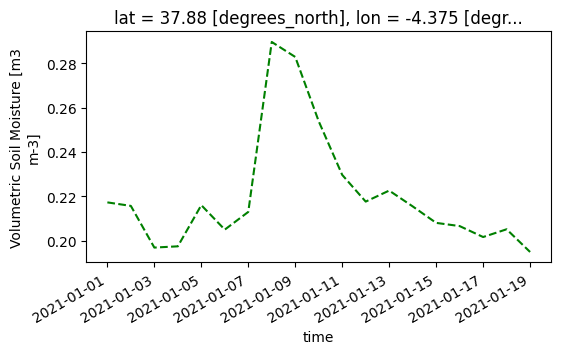

In [147]:
fig, ax = plt.subplots(1, figsize=(6,3))
ta_CBR.plot(linestyle='dashed',color='g', ax=ax);

In [41]:
########################################################################################################

### NOTES

- [assign coords:](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.assign_coords.html)
- [write netCDF:](https://stackoverflow.com/questions/64409180/save-netcdf-through-xarray-with-dimensions-given-by-two-coordinates)
- [xarray-docs-write netCDF](https://tutorial.xarray.dev/fundamentals/01.1_io.html)
- [rioxarray-write to geotiff](https://corteva.github.io/rioxarray/stable/examples/convert_to_raster.html)
- [rioxarray-CRS management](https://corteva.github.io/rioxarray/latest/getting_started/crs_management.html)
- [stackoverflow-write nc with gdal](https://gis.stackexchange.com/questions/379701/mapping-a-netcdf-in-qgis-in-the-correct-location-on-earth?rq=1)
- [cedo tools-correct projection](https://github.com/qgis/QGIS/issues/49348)
- [write netCDF](https://gis.stackexchange.com/questions/230093/set-projection-for-netcdf4-in-python)
- [get CRS from rasterio](https://github.com/pydata/xarray/issues/2288)
- [Xcdat](https://xcdat.readthedocs.io/en/stable/getting-started.html) - [Xcdat: temporal avg](https://xcdat.readthedocs.io/en/latest/generated/xarray.Dataset.temporal.group_average.html)
- [add CRS to xarray](https://github.com/xarray-contrib/xarray-tutorial/blob/main/fundamentals/01.1_io.ipynb)

**Tutorial**
- [xarray lesson_series-youtube](https://www.youtube.com/watch?v=0YsFR6xqic8)
- [thinking array](https://www.youtube.com/watch?v=TSw3GF_d2y8)
- [write netCDF: 46:00-48:00 video](https://www.youtube.com/watch?v=xdrcMi_FB8Q)
- [xarray fundamentals](https://www.youtube.com/watch?v=a339Q5F48UQ&list=WL&index=1)
      - line plot at `56:00`
      - rolling window mean at `1:40`
- [xarray-CORRECT-yearly average](https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/)
- [xarray-group into seasons](https://xarray.pydata.org/en/v0.9.6/examples/monthly-means.html)
- [xarray-resample/groupby operations](https://xarray.pydata.org/en/v0.9.5/time-series.html)
- [xarray-working with time](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html)
- [xarray in 45 minutes](https://oceanhackweek.org/ohw22/tutorials/00-Mon/xarray-in-45-min.html)
- [xarray-github tutorials](https://github.com/xarray-contrib/xarray-tutorial/tree/main)
  
      - weighted average: fundamentals->03.4_weighted.ipynb
      - Geography with Cartopy: fundamentals->04.3_geographic_plotting.ipynb

**Things to try**
- Check RUS video about multi-temporal analysis at 1:20 - [RUS](https://www.youtube.com/watch?v=CE6BeLPORIE)
- perform correlation analysis: [correlation](https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html)
